In [89]:
import numpy as np
import random
from copy import deepcopy

class Semantics:
    def __init__(self, utterances, truth_calc):
        """
        utterances: list of possible utterances (e.g., ["red", "blue"])
        """
        self.utterances = utterances
        self.truth_calc = truth_calc

    def utterance_space(self):
        """
        Return the set of utterances. `n` can be used if space depends on world size.
        """
        return self.utterances

    def is_true(self, utt, obs):
        """
        Returns True/False if utterance is true in a given state.
        """
        return self.truth_calc(utt, obs)

class World:
    def __init__(self, theta, world_parameters, obs_model, obs_generator):
        """
        thetas: list of possible latent states
        obs_model: function (theta, obs) -> likelihood P(obs | theta)
        """
        self.theta = theta
        self.world_parameters = world_parameters
        self.obs_model = obs_model
        self.obs_generator = obs_generator
        self.all_obs = None

    def obs_prob(self, obs, theta):
        """
        Return P(obs | theta).
        """
        return self.obs_model(obs, theta)
    
    def generate_all_obs(self):
        """
        Generate all possible observations using the provided generator function.
        """
        return self.obs_generator(world_parameters=self.world_parameters)
    
    def sample_obs(self):
        """
        Sample an observation according to P(obs | self.theta).
        """
        if self.all_obs is not None:
            all_obs = self.all_obs
        else:
            all_obs = self.generate_all_obs()
            self.all_obs = all_obs
        probs = np.array([self.obs_prob(obs, self.theta) for obs in all_obs])
        probs = probs / probs.sum()  # normalize to avoid floating-point issues
        return random.choices(all_obs, weights=probs, k=1)[0]

class Belief:
    def __init__(self, values, prior=None):
        """
        values: list of possible joint states, e.g. [(theta, psi), ...]
        prior: optional list of probabilities of same length
        """
        self.values = values
        if prior is None:
            self.prob = np.ones(len(values)) / len(values)
        else:
            self.prob = np.array(prior, dtype=float)
            self.prob /= np.sum(self.prob)

    def update(self, likelihoods):
        """
        likelihoods: array of same length as values
        """
        likelihoods = np.array(likelihoods, dtype=float)
        self.prob *= likelihoods
        if np.sum(self.prob) > 0:
            self.prob /= np.sum(self.prob)

    def as_dict(self):
        return dict(zip(self.values, self.prob))

    def marginal(self, index):
        """
        Compute marginal distribution over one coordinate.
        index = 0 for theta, 1 for psi
        """
        marg = {}
        for (theta, psi), p in zip(self.values, self.prob):
            key = (theta, psi)[index]
            marg[key] = marg.get(key, 0.0) + p
        return marg

class Speaker0:
    def __init__(self, thetas, semantics, world):
        """
        Speaker stores a belief over theta and reasons using a listener model.
        
        thetas    : list of possible theta values
        listener  : a Listener object from the lower level (e.g. L0 for S1)
        semantics : object defining utterance space, truth conditions
        """
        self.thetas = thetas
        self.belief_theta = Belief(thetas)
        self.semantics = semantics
        self.world = world
        
        self.hist = [deepcopy(self.belief_theta)]
        
        self.utterances_theta = {}

    def infer_state(self, obs):
        """
        Compute posterior over theta given an observation (Bayes update).
        """
        likelihoods = []
        for theta in self.thetas:
            likelihoods.append(self.world.obs_prob(obs, theta))

        posterior = Belief(self.thetas, self.belief_theta.prob.copy())
        posterior.update(likelihoods)
        return posterior

    def update(self, obs):
        """
        Update internal belief over theta after seeing an observation.
        """
        self.belief_theta = self.infer_state(obs)
        self.hist.append(deepcopy(self.belief_theta))
        
        self.utterances_theta = {}  # reset cached utterance distributions
        
        
        return self.belief_theta.as_dict()

    def dist_over_utterances_obs(self, obs):
        """
        For a literal speaker:
        Return uniform distribution over all utterances that are true for the given observation.
        """
        utterances = self.semantics.utterance_space()
        
        # Find all utterances that are true for this observation
        true_utterances = [utt for utt in utterances if self.semantics.is_true(utt, obs)]
        
        # uniform over the true utterances
        p = 1.0 / len(true_utterances)
        probs_dict = {utt: (p if utt in true_utterances else 0.0) for utt in utterances}
        
        return probs_dict

    def dist_over_utterances_theta(self, theta):
        if theta in self.utterances_theta:
            return self.utterances_theta[theta]
        probs = {u: 0.0 for u in self.semantics.utterance_space()}
        for obs in self.world.generate_all_obs():
            obs_prob = self.world.obs_prob(obs, theta)
            for utt, prob in self.dist_over_utterances_obs(obs).items():
                probs[utt] += prob * obs_prob
        self.utterances_theta[theta] = probs
        return probs
    
    def sample_utterance(self, obs):
        """
        Sample an utterance from the utterance distribution.
        """
        dist = self.dist_over_utterances(obs)
        utterances, probs = zip(*dist.items())
        return random.choices(utterances, weights=probs, k=1)[0]

class Listener0:
    def __init__(self, thetas, speaker, world, semantics):
        """
        Listener maintains a joint belief P(theta, psi).
        """
        self.state_belief = Belief(thetas)
        self.speaker = speaker
        self.world = world
        self.semantics = semantics
        
        self.hist = [deepcopy(self.state_belief)]
        
        self.prior_utt = None
        self.obs_utt = {}

    def infer_state(self, utt):
        """
        Compute posterior distribution P(theta, psi | utt) ∝ P(utt | theta, psi) * prior.
        """
        likelihoods = []
        for state in self.state_belief.values:
            # Call speaker model for likelihood
            utt_dist = self.speaker.dist_over_utterances_theta(state)
            likelihoods.append(utt_dist.get(utt, 0.0))
        
        # Posterior
        posterior = Belief(self.state_belief.values, self.state_belief.prob.copy())
        posterior.update(likelihoods)
        return posterior
    
    def infer_obs(self, utt):
        if utt in self.obs_utt:
            return self.obs_utt[utt]
        result = {}
        obs_prob = self.distribution_over_obs()
        utt_priors = self.prior_over_utt()
        for obs in self.world.generate_all_obs():
            # get precomputed priors (cached internally)     
            result[obs] = self.speaker.dist_over_utterances_obs(obs)[utt] * obs_prob[obs] / utt_priors[utt]
        self.obs_utt[utt] = result
        return result

    def distribution_over_obs(self):
        result = {}
        for obs in self.world.generate_all_obs():
            listener_obs = 0
            for (theta, theta_prob) in self.state_belief.as_dict().items():
                listener_obs += self.world.obs_prob(obs, theta) * theta_prob
            result[obs] = listener_obs
        return result
    
    def prior_over_utt(self):
        if self.prior_utt is not None:
            return self.prior_utt
        utt_priors = {}
        for utt in self.semantics.utterance_space():
            total = 0.0
            for obs_case in self.world.generate_all_obs():
                literal_speaker_utterance_obscase_val = self.speaker.dist_over_utterances_obs(obs_case)
                for (theta_case, theta_prob) in self.state_belief.as_dict().items():
                    obs_prior = self.world.obs_prob(obs_case, theta_case)
                    total += (
                        literal_speaker_utterance_obscase_val[utt]
                        * obs_prior
                        * theta_prob
                    )
            utt_priors[utt] = total
        self.prior_utt = utt_priors
        return utt_priors
    
    def update(self, utt):
        """
        Replace the current belief with the posterior after hearing utterance.
        """
        new_belief = self.infer_state(utt)
        self.state_belief = new_belief
        
        self.prior_utt = None
        self.obs_utt = {}
        
        self.hist.append(deepcopy(self.state_belief))
        
        return self.state_belief.as_dict()


class Speaker1:
    def __init__(self, thetas, listener, semantics, world, alpha=1.0, psi="inf"):
        """
        Speaker stores a belief over theta and reasons using a listener model.
        
        thetas    : list of possible theta values
        listener  : a Listener object from the lower level (e.g. L0 for S1)
        semantics : object defining utterance space, truth conditions
        alpha     : rationality parameter
        pers      : persuasion type ("inf", "high", "low")
        """
        self.thetas = thetas
        self.belief_theta = Belief(thetas)
        self.listener = listener
        self.semantics = semantics
        self.world = world
        self.alpha = alpha
        self.psi = psi
        
        self.hist = [deepcopy(self.belief_theta)]
        
        self.utterance_theta_psi = {}
        self.informativeness_obs_utt = {}
        self.persuasiveness_psi = {}
        self.utterances_obs_psi = {}

    def infer_state(self, obs):
        """
        Compute posterior over theta given an observation (Bayes update).
        """
        likelihoods = []
        for theta in self.thetas:
            likelihoods.append(self.world.obs_prob(obs, theta))

        posterior = Belief(self.thetas, self.belief_theta.prob.copy())
        posterior.update(likelihoods)
        return posterior

    def update(self, obs):
        """
        Update internal belief over theta after seeing an observation.
        """
        self.belief_theta = self.infer_state(obs)
        self.hist.append(deepcopy(self.belief_theta))
        
        self.utterance_theta_psi = {}
        self.informativeness_obs_utt = {}
        self.persuasiveness_psi = {}
        self.utterances_obs_psi = {}

        return self.belief_theta.as_dict()

    def get_informativeness_obs_utt(self, obs, utt):
        if (obs, utt) in self.informativeness_obs_utt:
            return self.informativeness_obs_utt[(obs, utt)]
        result = self.listener.infer_obs(utt)
        for (obs_case, prob) in result.items():
            self.informativeness_obs_utt[(obs_case, utt)] = prob
        return result[obs]
    
    def get_informativeness_obs(self, obs):
        result = {}
        for utt in self.semantics.utterance_space():
            result[utt] = self.listener.infer_obs(utt)[obs]
        return result

    def get_persuasiveness(self, pers):
        if pers in self.persuasiveness_psi:
            return self.persuasiveness_psi[pers]
        utterances = self.semantics.utterance_space()
        result = {u: 0.0 for u in utterances}

        for utt in utterances:
            if pers == "inf":
                result[utt] = 1
            elif pers == "high":
                for (theta, theta_prob) in self.listener.infer_state(utt).as_dict().items():
                    result[utt] += theta * theta_prob
            elif pers == "low":
                for (theta, theta_prob) in self.listener.infer_state(utt).as_dict().items():
                    result[utt] += theta * theta_prob
                result[utt] = 1 - result[utt]
        self.persuasiveness_psi[pers] = result
        return result

    def dist_over_utterances_obs(self, obs, psi):
        """
        Distribution over utterances given observation.
        Uses informativeness + persuasiveness.
        """
        if (obs, psi) in self.utterances_obs_psi:
            return self.utterances_obs_psi[(obs, psi)]
        utterances = self.semantics.utterance_space()
        persuasiveness = self.get_persuasiveness(psi)
        scores = []
        if psi == "inf":
            beta = 1.0
        else:
            beta = 0.0
        
        for utt in utterances:
            info_val = self.get_informativeness_obs_utt(obs, utt)
            pers_val = persuasiveness[utt]
            if info_val > 0:
                score = (info_val ** (self.alpha * beta)) * (pers_val ** (self.alpha * (1 - beta)))
            else:
                score = 0.0
            scores.append(score)

        scores = np.array(scores)
        probs = scores / np.sum(scores)
        self.utterances_obs_psi[(obs, psi)] = dict(zip(utterances, probs))
        return self.utterances_obs_psi[(obs, psi)]

    def dist_over_utterances_theta(self, theta, psi):
        if (theta, psi) in self.utterance_theta_psi:
            return self.utterance_theta_psi[(theta, psi)]
        result = {u: 0.0 for u in self.semantics.utterance_space()}
        for obs in self.world.generate_all_obs():
            obs_prob = self.world.obs_prob(obs, theta)
            for utt, prob in self.dist_over_utterances_obs(obs, psi).items():
                result[utt] += prob * obs_prob
        self.utterance_theta_psi[(theta, psi)] = result
        return result
    
    def sample_utterance(self, obs):
        """
        Sample an utterance from the utterance distribution.
        """
        dist = self.dist_over_utterances(obs, self.psi)
        utterances, probs = zip(*dist.items())
        return random.choices(utterances, weights=probs, k=1)[0]


class Listener1:
    def __init__(self, thetas, psis, speaker, world, semantics, listener_type, alpha=1.0):
        """
        Listener maintains a joint belief P(theta, psi).
        """
        if listener_type == "inf":
            psis = ["inf"]
        joint_values = [(theta, psi) for theta in thetas for psi in psis]
        self.state_belief = Belief(joint_values)
        self.speaker = speaker
        self.world = world
        self.semantics = semantics
        self.psis = psis
        self.alpha = alpha
        self.hist = [deepcopy(self.state_belief)]
        
        self.obs_psi_utt = {}
        self.obs_psi = None
        self.prior_utt = None
        self.obs_utt = {}

    def infer_state(self, utt):
        """
        Compute posterior distribution P(theta, psi | utt) ∝ P(utt | theta, psi) * prior.
        """
        likelihoods = []
        for state in self.state_belief.values:
            # Call speaker model for likelihood
            utt_dist = self.speaker.dist_over_utterances_theta(state[0], state[1])
            likelihoods.append(utt_dist.get(utt, 0.0))
        
        # Posterior
        posterior = Belief(self.state_belief.values, self.state_belief.prob.copy())
        posterior.update(likelihoods)
        return posterior

    def infer_obs(self, utt):
        if utt in self.obs_utt:
            return self.obs_utt[utt]
        result = {}
        obs_psi_utt = self.infer_obs_psi(utt)
        for obs in self.world.generate_all_obs():
            for psi in self.psis:
                result[obs] = result.get(obs, 0.0) + obs_psi_utt[(obs, psi)]
        self.obs_utt[utt] = result
        return result
    
    def infer_obs_psi(self, utt):
        if utt in self.obs_psi_utt:
            return self.obs_psi_utt[utt]
        result = {(obs,psi): 0.0 for obs in self.world.generate_all_obs() for psi in self.psis}
        obs_psi= self.distribution_over_obs_psi()
        utt_priors = self.prior_over_utt()
        for obs in self.world.generate_all_obs():
            # get precomputed priors (cached internally)   
            for psi in self.psis:
                result[(obs, psi)] = self.speaker.dist_over_utterances_obs(obs, psi)[utt] * obs_psi[(obs, psi)] / utt_priors[utt]
        self.obs_psi_utt[utt] = result
        return result
    
    def distribution_over_obs_psi(self):
        if self.obs_psi is not None:
            return self.obs_psi
        
        result = {(obs,psi): 0.0 for obs in self.world.generate_all_obs() for psi in self.psis}
        for (state, state_prob) in self.state_belief.as_dict().items():
            for obs in self.world.generate_all_obs():
                cur_obs_prob = self.world.obs_prob(obs, state[0])
                result[(obs, state[1])] += cur_obs_prob * state_prob
        self.obs_psi_utt = result
        return result
    
    def prior_over_utt(self):
        if self.prior_utt is not None:
            return self.prior_utt
        utt_priors = {utt: 0.0 for utt in self.semantics.utterance_space()}
        obs_psi_dist = self.distribution_over_obs_psi()
        for obs_case in self.world.generate_all_obs():
            for psi in self.psis:
                pragmatic_speaker_utterance_obscase_val = self.speaker.dist_over_utterances_obs(obs_case, psi)
                for utt in self.semantics.utterance_space():
                    utt_priors[utt] += pragmatic_speaker_utterance_obscase_val[utt] * obs_psi_dist[(obs_case, psi)]
                    
        self.prior_utt = utt_priors
        return utt_priors
    
    def update(self, utt):
        """
        Replace the current belief with the posterior after hearing utterance.
        """
        new_belief = self.infer_state(utt)
        self.state_belief = new_belief
        self.hist.append(deepcopy(self.state_belief))
        
        self.obs_psi_utt = {}
        self.obs_psi = None
        self.prior_utt = None
        self.obs_utt = {}
        
        return self.state_belief
    
    def marginal_theta(self):
        """
        Return the marginal distribution over theta.
        """
        theta_probs = {}
        for (theta, psi), p in zip(self.state_belief.values, self.state_belief.prob):
            theta_probs[theta] = theta_probs.get(theta, 0.0) + p
        return theta_probs

    def marginal_psi(self):
        """
        Return the marginal distribution over psi.
        """
        psi_probs = {}
        for (theta, psi), p in zip(self.state_belief.values, self.state_belief.prob):
            psi_probs[psi] = psi_probs.get(psi, 0.0) + p
        return psi_probs


class Speaker2:
    def __init__(self, thetas, listener, semantics, world, alpha=1.0, psi="inf"):
        """
        Speaker stores a belief over theta and reasons using a listener model.
        
        thetas    : list of possible theta values
        listener  : a Listener object from the lower level (e.g. L0 for S1)
        semantics : object defining utterance space, truth conditions
        alpha     : rationality parameter
        pers      : persuasion type ("inf", "high", "low")
        """
        self.thetas = thetas
        self.belief_theta = Belief(thetas)
        self.listener = listener
        self.semantics = semantics
        self.world = world
        self.alpha = alpha
        self.psi = psi
        
        self.hist = [deepcopy(self.belief_theta)]
        
        self.utterance_theta_psi = {}
        self.informativeness_obs_utt = {}
        self.persuasiveness_psi = {}
        self.utterances_obs_psi = {}

    def infer_state(self, obs):
        """
        Compute posterior over theta given an observation (Bayes update).
        """
        likelihoods = []
        for theta in self.thetas:
            likelihoods.append(self.world.obs_prob(obs, theta))

        posterior = Belief(self.thetas, self.belief_theta.prob.copy())
        posterior.update(likelihoods)
        return posterior

    def update(self, obs):
        """
        Update internal belief over theta after seeing an observation.
        """
        self.belief_theta = self.infer_state(obs)
        self.hist.append(deepcopy(self.belief_theta))
        
        self.utterance_theta_psi = {}
        self.informativeness_obs_utt = {}
        self.persuasiveness_psi = {}
        self.utterances_obs_psi = {}
        return self.belief_theta.as_dict()

    def get_informativeness_obs_utt(self, obs, utt):
        if (obs, utt) in self.informativeness_obs_utt:
            return self.informativeness_obs_utt[(obs, utt)]
        result = self.listener.infer_obs(utt)
        for (obs_case, prob) in result.items():
            self.informativeness_obs_utt[(obs_case, utt)] = prob
        return result[obs]
    
    def get_informativeness_obs(self, obs):
        result = {}
        for utt in self.semantics.utterance_space():
            result[utt] = self.listener.infer_obs(utt)[obs]
        return result

    def get_persuasiveness(self, pers):
        if pers in self.persuasiveness_psi:
            return self.persuasiveness_psi[pers]
        utterances = self.semantics.utterance_space()
        result = {u: 0.0 for u in utterances}

        for utt in utterances:
            if pers == "inf":
                result[utt] = 1
            elif pers == "high":
                for (state, state_prob) in self.listener.infer_state(utt).as_dict().items():
                    result[utt] += state[0] * state_prob
            elif pers == "low":
                for (state, state_prob) in self.listener.infer_state(utt).as_dict().items():
                    result[utt] += state[0] * state_prob
                result[utt] = 1 - result[utt]
        self.persuasiveness_psi[pers] = result
        return result

    def dist_over_utterances_obs(self, obs, psi):
        """
        Distribution over utterances given observation.
        Uses informativeness + persuasiveness.
        """
        if (obs, psi) in self.utterances_obs_psi:
            return self.utterances_obs_psi[(obs, psi)]
        utterances = self.semantics.utterance_space()
        persuasiveness = self.get_persuasiveness(psi)
        scores = []
        if psi == "inf":
            beta = 1.0
        else:
            beta = 0.0
        
        for utt in utterances:
            info_val = self.get_informativeness_obs_utt(obs, utt)
            pers_val = persuasiveness[utt]
            if info_val > 0:
                score = (info_val ** (self.alpha * beta)) * (pers_val ** (self.alpha * (1 - beta)))
            else:
                score = 0.0
            scores.append(score)

        scores = np.array(scores)
        probs = scores / np.sum(scores)
        self.utterances_obs_psi[(obs, psi)] = dict(zip(utterances, probs))
        return self.utterances_obs_psi[(obs, psi)]

    def dist_over_utterances_theta(self, theta, psi):
        if (theta, psi) in self.utterance_theta_psi:
            return self.utterance_theta_psi[(theta, psi)]
        result = {u: 0.0 for u in self.semantics.utterance_space()}
        for obs in self.world.generate_all_obs():
            obs_prob = self.world.obs_prob(obs, theta)
            for utt, prob in self.dist_over_utterances_obs(obs, psi).items():
                result[utt] += prob * obs_prob
        self.utterance_theta_psi[(theta, psi)] = result
        return result
    
    def sample_utterance(self, obs):
        """
        Sample an utterance from the utterance distribution.
        """
        dist = self.dist_over_utterances_obs(obs, self.psi)
        utterances, probs = zip(*dist.items())
        return random.choices(utterances, weights=probs, k=1)[0]

def Game(thetas, psis, semantics, world, speaker_type="inf", listener_type="inf", alpha=1.0, rounds=1):
    """
    Play a game of communication between a speaker and a listener.
    """
    literal_speaker = Speaker0(thetas, semantics=semantics, world=world)
    literal_listener = Listener0(thetas, literal_speaker, semantics=semantics, world=world)
    pragmatic_speaker_1 = Speaker1(thetas, literal_listener, semantics=semantics, world=world, alpha=alpha, psi=speaker_type)
    pragmatic_listener_1 = Listener1(thetas, psis, pragmatic_speaker_1, semantics=semantics, world=world, alpha=alpha, listener_type=listener_type)
    pragmatic_speaker_2 = Speaker2(thetas, pragmatic_listener_1, semantics=semantics, world=world, alpha=alpha, psi=speaker_type)
    
    for r in range(rounds):
        print(f"--- Round {r+1} ---")
        obs = world.sample_obs()
        print(f"World theta: {world.theta}, observation: {obs}")
        
        utt = pragmatic_speaker_2.sample_utterance(obs)
        print(f"Speaker uttered: {utt}")
        
        pragmatic_speaker_2.update(obs)
        pragmatic_listener_1.update(utt)
        pragmatic_speaker_1.update(obs)
        literal_listener.update(utt)
        literal_speaker.update(obs)
    return pragmatic_speaker_2, pragmatic_listener_1, pragmatic_speaker_1, literal_listener, literal_speaker

In [90]:
import uuid
import datetime
import json
from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Tuple

# ----------------------
# Experiment logger
# ----------------------
@dataclass
class ExperimentLogger:
    params: Dict[str, Any]
    id: str = field(default_factory=lambda: str(uuid.uuid4()))
    timestamp: str = field(default_factory=lambda: datetime.datetime.now().isoformat())
    rounds: List[Dict[str, Any]] = field(default_factory=list)
    agent_histories: Dict[str, Optional[List[Any]]] = field(default_factory=dict)  # filled by finalize()

    def log_round(self, round_idx: int, world_theta: Any, observation: Any, utterance: Any, extra: Dict[str, Any] = None):
        """Log the minimal per-round info. Do NOT copy agent.hist here."""
        entry = {
            "round": round_idx,
            "world_theta": world_theta,
            "observation": observation,
            "utterance": utterance
        }
        if extra:
            entry.update(extra)
        self.rounds.append(entry)

    def finalize(self, agents: Dict[str, Any], copy_hist: bool = True):
        """
        Snapshot agents' `hist` attributes once at the end of the experiment.
        This intentionally stores per-agent `hist` only once (not every round).
        """
        for name, agent in agents.items():
            hist = getattr(agent, "hist", None)  # your agents use self.hist = []
            if hist is None:
                self.agent_histories[name] = None
            else:
                self.agent_histories[name] = list(hist) if copy_hist else hist

    # helpers for serializing (safe fallback: str(...) for non-JSON-serializable objects)
    def _make_serializable(self, obj):
        try:
            json.dumps(obj)
            return obj
        except (TypeError, OverflowError):
            return str(obj)

    def to_dict(self, serializable: bool = False) -> Dict[str, Any]:
        meta = {"id": self.id, "timestamp": self.timestamp, "params": self.params}
        rounds = self.rounds
        agent_histories = self.agent_histories
        if serializable:
            meta["params"] = {k: self._make_serializable(v) for k, v in self.params.items()}
            rounds = [{k: self._make_serializable(v) for k, v in r.items()} for r in rounds]
            agent_histories = {k: ([self._make_serializable(v) for v in hist] if hist is not None else None)
                               for k, hist in agent_histories.items()}
        return {"meta": meta, "rounds": rounds, "agent_histories": agent_histories}

    def to_json(self, filename: Optional[str] = None, serializable: bool = True) -> Optional[str]:
        """Write to a file (or return json string if filename is None)."""
        d = self.to_dict(serializable=serializable)
        j = json.dumps(d, indent=2)
        if filename:
            with open(filename, "w") as f:
                f.write(j)
            return None
        return j


# ----------------------
# Runner functions
# ----------------------
def run_game(thetas, psis, semantics, world,
             speaker_type="inf", listener_type="inf", alpha=1.0, rounds: int = 1,
             verbose: bool = False) -> Tuple[ExperimentLogger, Dict[str, Any]]:
    """
    Modern runner: returns (logger, agents_dict).
    - logger.rounds contains minimal per-round logs (no agent.hist duplication).
    - logger.finalize(...) is called automatically to snapshot agent.hist once.
    - agents_dict contains references to the live agent objects (so caller can inspect agent.hist)
    """
    # initialize agents (your existing constructors)
    literal_speaker = Speaker0(thetas, semantics=semantics, world=world)
    literal_listener = Listener0(thetas, literal_speaker, semantics=semantics, world=world)
    pragmatic_speaker_1 = Speaker1(thetas, literal_listener, semantics=semantics, world=world, alpha=alpha, psi=speaker_type)
    pragmatic_listener_1 = Listener1(thetas, psis, pragmatic_speaker_1, semantics=semantics, world=world, alpha=alpha, listener_type=listener_type)
    pragmatic_speaker_2 = Speaker2(thetas, pragmatic_listener_1, semantics=semantics, world=world, alpha=alpha, psi=speaker_type)

    params = {
        "thetas": thetas,
        "psis": psis,
        "semantics": str(semantics),
        "world": str(world),
        "speaker_type": speaker_type,
        "listener_type": listener_type,
        "alpha": alpha,
        "rounds": rounds,
    }
    logger = ExperimentLogger(params=params)

    agents = {
        "pragmatic_speaker_2": pragmatic_speaker_2,
        "pragmatic_listener_1": pragmatic_listener_1,
        "pragmatic_speaker_1": pragmatic_speaker_1,
        "literal_listener": literal_listener,
        "literal_speaker": literal_speaker,
    }

    for r in range(1, rounds + 1):
        if verbose:
            print(f"--- Round {r} ---")
        obs = world.sample_obs()
        if verbose:
            print(f"World theta: {world.theta}, observation: {obs}")

        utt = pragmatic_speaker_2.sample_utterance(obs)
        if verbose:
            print(f"Speaker uttered: {utt}")

        # belief updates (your original order)
        pragmatic_speaker_2.update(obs)
        pragmatic_listener_1.update(utt)
        pragmatic_speaker_1.update(obs)
        literal_listener.update(utt)
        literal_speaker.update(obs)

        # minimal per-round log (no agent.hist here)
        logger.log_round(r, world.theta, obs, utt)

    # snapshot agent.hist once
    logger.finalize(agents)
    return logger, agents


# ----------------------
# Backwards-compatible wrapper
# ----------------------
def Game(thetas, psis, semantics, world,
         speaker_type="inf", listener_type="inf", alpha=1.0, rounds: int = 1, verbose: bool = False):
    """
    Backwards-compatible Game(...) which returns the same five agents as before,
    BUT also attaches the ExperimentLogger to the top-level returned speaker as
    `pragmatic_speaker_2.experiment_log` for convenience.
    Old call-pattern:
        ps2, pl1, ps1, ll, ls = Game(...)
    New convenience:
        ps2.experiment_log  # contains ExperimentLogger with rounds + final agent hist snapshots
    """
    logger, agents = run_game(thetas, psis, semantics, world,
                              speaker_type=speaker_type, listener_type=listener_type,
                              alpha=alpha, rounds=rounds, verbose=verbose)
    # attach logger to the returned top-level speaker for backward compat
    agents["pragmatic_speaker_2"].experiment_log = logger
    # return agents in the old tuple order (so your existing code doesn't break)
    return (agents["pragmatic_speaker_2"],
            agents["pragmatic_listener_1"],
            agents["pragmatic_speaker_1"],
            agents["literal_listener"],
            agents["literal_speaker"])

In [92]:
from scipy.special import binom
import math
from functools import lru_cache

def generate_all_observations(world_parameters):
    """
    Generate all possible observation histograms for n patients and m sessions.
    Each histogram is a tuple of length m+1, summing to n.
    """
    n = world_parameters["n"]
    m = world_parameters["m"]
    observations = []

    def helper(current, depth, remaining):
        if depth == m:
            current.append(remaining)
            observations.append(tuple(current))
            current.pop()
            return
        for i in range(remaining + 1):
            current.append(i)
            helper(current, depth + 1, remaining - i)
            current.pop()

    helper([], 0, n)
    return observations

@lru_cache(maxsize=None)
def utterance_is_true(u, obs):
    """Evaluate if utterance u = (q1, q2, pred) is true given obs[n x m]"""
    if sum(obs) > 1:
        q1, q2, pred = u
        n = sum(obs)
        m = len(obs) - 1
        k = 0
        if pred == "ineffective":
            obs = obs[::-1]  # Reverse obs to treat "ineffective" as the last element
        
        # Step 1: apply q2 to each patient
        if q2 == "none":
            k = obs[0]
        elif q2 == "some":
            k = sum(obs[1:])
        elif q2 == "most":
            k = sum(obs[math.floor(m / 2) + (m % 2) : ])
        elif q2 == "all":
            k = obs[-1]

        # Step 2: apply q1 across patients
        if q1 == "none":
            return k == 0
        elif q1 == "some":
            return k >= 1
        elif q1 == "most":
            return k > (n / 2)
        elif q1 == "all":
            return k == n
    else:
        """Evaluate if utterance u = (q2, pred) is true given obs[1 x m]"""
        q2, pred = u
        m = len(obs) - 1
        patient_score = obs.index(1) if pred == "effective" else m - obs.index(1)

        if q2 == "none":
            return patient_score == 0
        elif q2 == "some":
            return patient_score > 0
        elif q2 == "most":
            return patient_score > (m / 2)
        elif q2 == "all":
            return patient_score == m

@lru_cache(maxsize=None)  
def multinomial(params):
    if len(params) == 1:
        return 1
    return binom(sum(params), params[-1]) * multinomial(params[:-1])

@lru_cache(maxsize=None)
def get_obs_prob(obs, theta):
    n = sum(obs)
    m = len(obs) - 1
    flat_prob = 1
    def helper(effective):
        return math.comb(m, effective) * (theta ** effective) * ((1 - theta) ** (m - effective))
    for i in range(len(obs)):
        flat_prob *= helper(i) ** obs[i]
    return flat_prob * multinomial(obs)

In [103]:
from itertools import product
theta = 0.3
thetas = [0.1 * i for i in range(0, 11)]
psis = ["inf", "high", "low"]
world_parameters = {"n": 5, "m": 7}
alpha = 3.0
rounds = 40
speaker_type = "low"
listener_type = "vig"

world = World(theta, world_parameters, get_obs_prob, generate_all_observations)
quantifiers = ["none", "some", "most", "all"]
predicates = ["effective", "ineffective"]
if world_parameters["n"] > 1:
    utterances = list(product(quantifiers, quantifiers, predicates))
else:
    utterances = list(product(quantifiers, predicates))

semantics = Semantics(utterances, utterance_is_true)

logger, agents = run_game(thetas = thetas, psis = psis, semantics = semantics, world = world, alpha=alpha, rounds=rounds, speaker_type=speaker_type, listener_type=listener_type, verbose=True)

--- Round 1 ---
World theta: 0.3, observation: (0, 0, 2, 2, 0, 1, 0, 0)
Speaker uttered: ('none', 'all', 'ineffective')
--- Round 2 ---
World theta: 0.3, observation: (2, 1, 2, 0, 0, 0, 0, 0)
Speaker uttered: ('none', 'most', 'effective')
--- Round 3 ---
World theta: 0.3, observation: (0, 4, 1, 0, 0, 0, 0, 0)
Speaker uttered: ('most', 'most', 'ineffective')
--- Round 4 ---
World theta: 0.3, observation: (0, 2, 1, 1, 1, 0, 0, 0)
Speaker uttered: ('none', 'none', 'ineffective')
--- Round 5 ---
World theta: 0.3, observation: (1, 2, 2, 0, 0, 0, 0, 0)
Speaker uttered: ('most', 'some', 'effective')
--- Round 6 ---
World theta: 0.3, observation: (1, 0, 1, 2, 1, 0, 0, 0)
Speaker uttered: ('most', 'some', 'effective')
--- Round 7 ---
World theta: 0.3, observation: (1, 2, 1, 1, 0, 0, 0, 0)
Speaker uttered: ('some', 'none', 'effective')
--- Round 8 ---
World theta: 0.3, observation: (1, 1, 2, 1, 0, 0, 0, 0)
Speaker uttered: ('most', 'some', 'ineffective')
--- Round 9 ---
World theta: 0.3, observa

In [142]:
from itertools import product
import pickle
theta = 0.9
thetas = [0.1 * i for i in range(0, 11)]
psis = ["inf", "high", "low"]
world_parameters = {"n": 5, "m": 7}
alpha = 3.0
rounds = 50
#speaker_type = "low"
#listener_type = "vig"

world = World(theta, world_parameters, get_obs_prob, generate_all_observations)
quantifiers = ["none", "some", "most", "all"]
predicates = ["effective", "ineffective"]
if world_parameters["n"] > 1:
    utterances = list(product(quantifiers, quantifiers, predicates))
else:
    utterances = list(product(quantifiers, predicates))

semantics = Semantics(utterances, utterance_is_true)

exp_total = 10
for i in range(5, 10):
    for listener_type in ["vig"]:
        for speaker_type in ["low"]:
            for theta in [0.8]:
                world = World(theta, world_parameters, get_obs_prob, generate_all_observations)
                #starting experiment
                print(f"Starting experiment {i+1}/{exp_total}, speaker: {speaker_type}, listener: {listener_type}, theta: {theta}")
                logger, agents = run_game(thetas = thetas, psis = psis, semantics = semantics, world = world, alpha=alpha, rounds=rounds, speaker_type=speaker_type, listener_type=listener_type, verbose=False)
                filename = f"exp_{i+1}_s-{speaker_type}_l-{listener_type}_t-{theta}"
                with open(filename + "_logger.pkl", 'wb') as f:
                    pickle.dump(logger, f)
                with open(filename + "_agents.pkl", 'wb') as f:
                    pickle.dump(agents, f)
                print(f"Finished experiment {i+1}/{exp_total}, speaker: {speaker_type}, listener: {listener_type}, theta: {theta}")

Starting experiment 6/10, speaker: low, listener: vig, theta: 0.8
Finished experiment 6/10, speaker: low, listener: vig, theta: 0.8
Starting experiment 7/10, speaker: low, listener: vig, theta: 0.8
Finished experiment 7/10, speaker: low, listener: vig, theta: 0.8
Starting experiment 8/10, speaker: low, listener: vig, theta: 0.8
Finished experiment 8/10, speaker: low, listener: vig, theta: 0.8
Starting experiment 9/10, speaker: low, listener: vig, theta: 0.8
Finished experiment 9/10, speaker: low, listener: vig, theta: 0.8
Starting experiment 10/10, speaker: low, listener: vig, theta: 0.8
Finished experiment 10/10, speaker: low, listener: vig, theta: 0.8


In [138]:
import pickle
with open("ag.pkl", "wb") as f:
    pickle.dump(agents_4, f)

# Load
with open("ag.pkl", "rb") as f:
    agents_reloaded = pickle.load(f)
    
agents_reloaded['pragmatic_listener_1'].hist[0].marginal(1)

{'inf': np.float64(0.33333333333333326),
 'high': np.float64(0.33333333333333326),
 'low': np.float64(0.33333333333333326)}

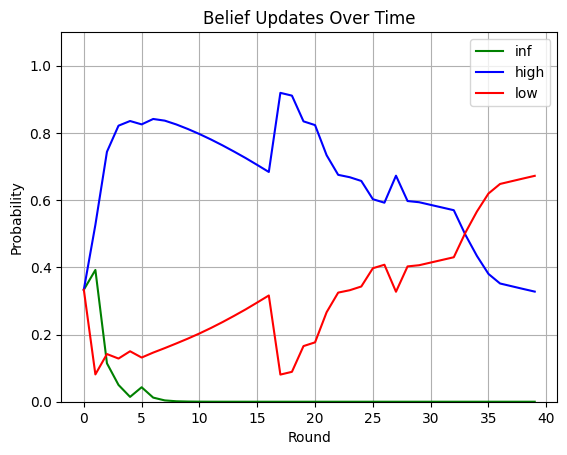

In [135]:
psis = {"inf": [], "high": [], "low": []}
for belief in agents_4["pragmatic_listener_1"].hist[0:40]:
    for (psi, prob) in belief.marginal(1).items():
        psis[psi].append(prob)

import matplotlib.pyplot as plt
for psi, values in psis.items():
    #make inf green, high blue, low red
    if psi == "inf":
        plt.plot(values, label=psi, color="green")
    elif psi == "high":
        plt.plot(values, label=psi, color="blue")
    elif psi == "low":
        plt.plot(values, label=psi, color="red")
plt.ylim(0, 1.1)
#add grid
plt.grid(True)
plt.xlabel("Round")
plt.ylabel("Probability")
plt.title("Belief Updates Over Time")
plt.legend()
plt.show()

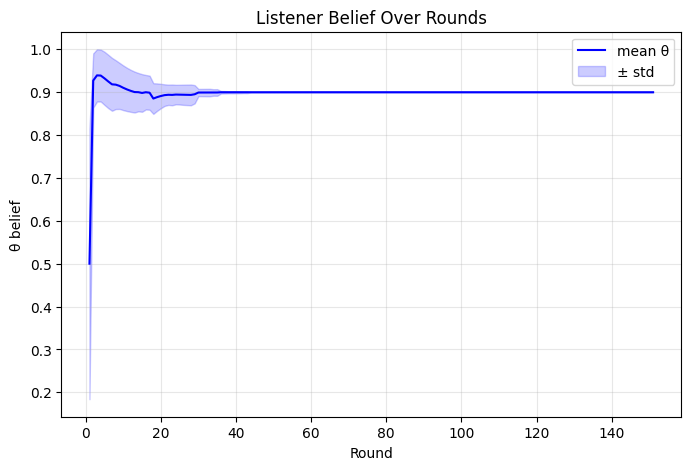

In [126]:
import numpy as np

def summarize_beliefs(belief_hist):
    thetas = np.array(sorted(belief_hist[0].keys()))
    means, ses = [], []
    for dist in belief_hist:
        ps = np.array([dist[th] for th in thetas])
        mean = np.sum(thetas * ps)
        var = np.sum((thetas - mean)**2 * ps)
        std = np.sqrt(var)
        # SE = std / sqrt(N); here N=1 distribution per round, so just use std as uncertainty
        se = std
        means.append(mean)
        ses.append(se)
    return np.arange(1, len(belief_hist)+1), np.array(means), np.array(ses)

theta_beliefs = []
for belief in agents_3["pragmatic_listener_1"].hist:
    theta_beliefs.append(belief.marginal(0))

rounds, means, ses = summarize_beliefs(theta_beliefs)

plt.figure(figsize=(8,5))
plt.plot(rounds, means, label="mean θ", color="blue")
plt.fill_between(rounds, means - ses, means + ses, color="blue", alpha=0.2, label="± std")

plt.xlabel("Round")
plt.ylabel("θ belief")
plt.title("Listener Belief Over Rounds")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [104]:
logger.to_json(filename="experiment_1_log.json", serializable=True)

In [ ]:
import json

# Load the file
with open("experiment_1_log.json", "r") as f:
    data = json.load(f)

# Fetch belief history of one agent
ps2_hist = data["agent_histories"]["pragmatic_speaker_2"]

print("Belief history of pragmatic_speaker_2:", ps2_hist[0])


AttributeError: 'str' object has no attribute 'marginal'

In [86]:
from itertools import product
theta = 0.3
thetas = [0.1 * i for i in range(0, 11)]
psis = ["inf", "high", "low"]
world_parameters = {"n": 5, "m": 7}
alpha = 3.0
world = World(theta, world_parameters, get_obs_prob, generate_all_observations)
quantifiers = ["none", "some", "most", "all"]
predicates = ["effective", "ineffective"]
if world_parameters["n"] > 1:
    utterances = list(product(quantifiers, quantifiers, predicates))
else:
    utterances = list(product(quantifiers, predicates))

semantics = Semantics(utterances, utterance_is_true)
speaker_low, listener_low = Game(thetas, psis, semantics, world, alpha=alpha, rounds=10)


--- Round 1 ---
World theta: 0.3, observation: (0, 1, 2, 2, 0, 0, 0, 0)
Speaker uttered: ('most', 'some', 'ineffective')
--- Round 2 ---
World theta: 0.3, observation: (0, 2, 3, 0, 0, 0, 0, 0)
Speaker uttered: ('some', 'some', 'ineffective')
--- Round 3 ---
World theta: 0.3, observation: (3, 1, 0, 1, 0, 0, 0, 0)
Speaker uttered: ('some', 'some', 'ineffective')
--- Round 4 ---
World theta: 0.3, observation: (2, 0, 0, 2, 0, 1, 0, 0)
Speaker uttered: ('some', 'some', 'effective')
--- Round 5 ---
World theta: 0.3, observation: (0, 1, 3, 0, 1, 0, 0, 0)
Speaker uttered: ('most', 'most', 'ineffective')
--- Round 6 ---
World theta: 0.3, observation: (0, 2, 1, 1, 1, 0, 0, 0)
Speaker uttered: ('some', 'most', 'ineffective')
--- Round 7 ---
World theta: 0.3, observation: (0, 2, 1, 0, 1, 1, 0, 0)
Speaker uttered: ('most', 'some', 'effective')
--- Round 8 ---
World theta: 0.3, observation: (1, 3, 1, 0, 0, 0, 0, 0)
Speaker uttered: ('some', 'none', 'effective')
--- Round 9 ---
World theta: 0.3, obse

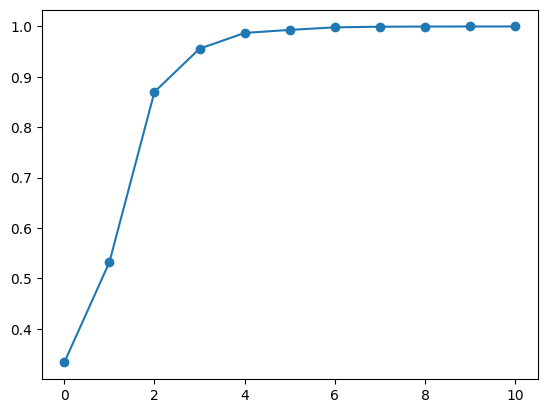

In [82]:
#plot informativity probability
import matplotlib.pyplot as plt
hist = listener.hist
y = []
for belief in hist:
    marg = belief.marginal(1)["inf"]
    y.append(marg)
plt.plot(y, marker='o')

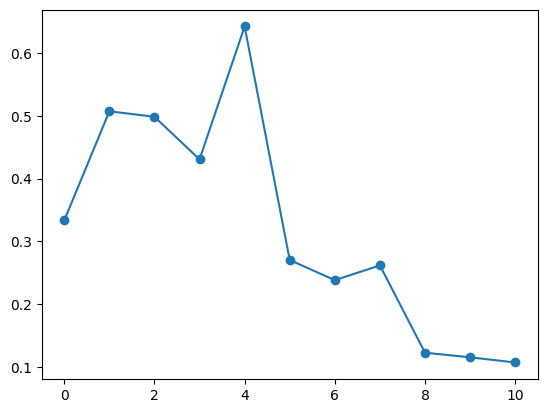

In [88]:
#plot informativity probability
import matplotlib.pyplot as plt
hist = listener_low.hist
y = []
for belief in hist:
    marg = belief.marginal(1)["low"]
    y.append(marg)
plt.plot(y, marker='o')

In [54]:

theta = 0.3
world_parameters = {"n": 5, "m": 7}
alpha = 3.0
world = World(theta, world_parameters, get_obs_prob, generate_all_observations)


quantifiers = ["none", "some", "most", "all"]
predicates = ["effective", "ineffective"]
if world_parameters["n"] > 1:
    utterances = list(product(quantifiers, quantifiers, predicates))
else:
    utterances = list(product(quantifiers, predicates))

semantics = Semantics(utterances, utterance_is_true)
thetas = [0.1 * i for i in range(0, 11)]
literal_speaker = Speaker0(thetas, semantics=semantics, world=world)
literal_listener = Listener0(thetas, literal_speaker, world=world, semantics=semantics)
pragmatic_speaker = Speaker1(thetas, literal_listener, semantics=semantics, world=world, alpha=alpha, psi="inf")
pragmatic_listener = Listener1(thetas, ["inf", "high", "low"], pragmatic_speaker, semantics=semantics, world=world, alpha=alpha)
#pragmatic_speaker.dist_over_utterances_obs((0, 4, 0, 0, 0, 0, 1, 0), "inf")
# pragmatic_speaker.dist_over_utterances_theta(0.3, "inf")
pragmatic_speaker2 = Speaker2(thetas, pragmatic_listener, semantics=semantics, world=world, alpha=alpha, psi="inf")
pragmatic_speaker2.dist_over_utterances_obs((0, 4, 0, 0, 0, 0, 1, 0), "inf")


[(('most', 'most', 'ineffective'), np.float64(0.49770994795540136)),
 (('some', 'most', 'effective'), np.float64(0.07791617720222929)),
 (('none', 'none', 'effective'), np.float64(0.06266858516019767)),
 (('none', 'all', 'ineffective'), np.float64(0.06266858516019767)),
 (('all', 'some', 'effective'), np.float64(0.06266858516019767)),
 (('some', 'most', 'ineffective'), np.float64(0.056962002820101255)),
 (('none', 'none', 'ineffective'), np.float64(0.046442181241311394)),
 (('none', 'all', 'effective'), np.float64(0.046442181241311394)),
 (('all', 'some', 'ineffective'), np.float64(0.046442181241311394)),
 (('most', 'some', 'effective'), np.float64(0.013027535523013715)),
 (('most', 'some', 'ineffective'), np.float64(0.01090085636831146)),
 (('some', 'some', 'effective'), np.float64(0.008577027124095981)),
 (('some', 'some', 'ineffective'), np.float64(0.007574153802319839)),
 (('none', 'some', 'effective'), np.float64(0.0)),
 (('none', 'some', 'ineffective'), np.float64(0.0)),
 (('none

In [27]:
from itertools import product
from functools import lru_cache
quantifiers = ["none", "some", "most", "all"]
predicates = ["effective", "ineffective"]

def generate_all_observations(n, m):
    """
    Generate all possible observation histograms for n patients and m sessions.
    Each histogram is a tuple of length m+1, summing to n.
    """
    observations = []

    def helper(current, depth, remaining):
        if depth == m:
            current.append(remaining)
            observations.append(tuple(current))
            current.pop()
            return
        for i in range(remaining + 1):
            current.append(i)
            helper(current, depth + 1, remaining - i)
            current.pop()

    helper([], 0, n)
    return observations

def literal_speaker_utterance_obs(obs, quantifiers=quantifiers, predicates=predicates):
    """Return uniform distribution over all true utterances"""
    if sum(obs) > 1:
        utterances = list(product(quantifiers, quantifiers, predicates))
    else:
        utterances = list(product(quantifiers, predicates))
    true_utterances = [u for u in utterances if utterance_is_true(u, obs)]
    if not true_utterances:
        return {}
    p = 1.0 / len(true_utterances)
    result = {}
    for u in utterances:
        if u in true_utterances:
            result[u] = p
        else:
            result[u] = 0.0
    return result

@lru_cache(maxsize=None)
def literal_speaker_utterance_theta(theta, n, m, quantifiers=quantifiers, predicates=predicates, N = 1000):
    """Estimate literal speaker utterance distribution given theta via sampling"""
    if n > 1:
        utterances = list(product(quantifiers, quantifiers, predicates))
    else:
        utterances = list(product(quantifiers, predicates))
        
    probs = {u: 0.0 for u in utterances}
    observations = generate_all_observations(n, m)
    for obs in observations:
        obs_prob = get_obs_prob(obs, theta)
        for utt, prob in literal_speaker_utterance_obs(obs).items():
            probs[utt] += prob * obs_prob
    return probs

def literal_listener_theta_utterance(utterance, n = 10, m = 20, thetas=thetas, N = 1000):
    probs = {}
    for theta in thetas:
        utterance_probs = literal_speaker_utterance_theta(theta, n=n, m=m)
        probs[theta] = utterance_probs.get(tuple(utterance), 0.0) / len(thetas)
    total = sum(probs.values())
    return [p / total for p in probs.values()]


@lru_cache(maxsize=None)
def get_literal_listener_utt(n, m, thetas_tuple, quantifiers_tuple):
    if n > 1:
        utterances = list(product(quantifiers_tuple, quantifiers_tuple, ["effective", "ineffective"]))
    else:
        utterances = list(product(quantifiers_tuple, ["effective", "ineffective"]))

    all_obs = generate_all_observations(n, m)
    utt_priors = {}
    for utt in utterances:
        total = 0.0
        for obs_case in all_obs:
            literal_speaker_utterance_obscase_val = literal_speaker_utterance_obs(obs_case, quantifiers_tuple, ["effective", "ineffective"])
            for theta_case in thetas_tuple:
                obs_prior = get_obs_prob(obs_case, theta_case) 
                total += (
                    literal_speaker_utterance_obscase_val[utt]
                    * obs_prior
                    * (1 / len(thetas_tuple))
                )
        utt_priors[utt] = total
    return utt_priors

def informativeness_all_utterances(obs, thetas, quantifiers=["none", "some", "most", "all"], N=1000):
    n = sum(obs)
    m = len(obs) - 1

    # ---- cache for literal_listener_utt ----


    # ---- normal part depending on obs ----
    if n > 1:
        utterances = list(product(quantifiers, quantifiers, ["effective", "ineffective"]))
    else:
        utterances = list(product(quantifiers, ["effective", "ineffective"]))

    result = {}
    total_success = sum(obs[i] * i for i in range(len(obs)))
    literal_speaker_utterance_obs_val = literal_speaker_utterance_obs(obs, quantifiers, ["effective", "ineffective"])

    literal_listener_obs = 0
    for theta in thetas:
        literal_listener_obs += get_obs_prob(obs, theta) * (1 / len(thetas))

    # get precomputed priors (cached internally)
    utt_priors = get_literal_listener_utt(n, m, tuple(thetas), tuple(quantifiers))

    for utt in utterances:
        result[utt] = (
            literal_speaker_utterance_obs_val[utt]
            * literal_listener_obs
            / utt_priors[utt]
        )
    return result


def persuasiveness_all_utterances(pers, n = 10, m = 20, thetas=thetas, quantifiers=["none", "some", "most", "all"], predicates=["effective", "ineffective"], N = 1000):
    if n > 1:
        utterances = list(product(quantifiers, quantifiers, predicates))
    else:
        utterances = list(product(quantifiers, predicates))
        
    result = {u: 0.0 for u in utterances}

    for utt in utterances:
        if pers == "inf":
            result[utt] = 1
        elif pers == "high":
            theta_dist = literal_listener_theta_utterance(utt, n=n, m=m, thetas=thetas, N=N)
            for i in range(len(theta_dist)):
                result[utt] += theta_dist[i] * thetas[i]
        elif pers == "low":
            theta_dist = literal_listener_theta_utterance(utt, n=n, m=m, thetas=thetas, N=N)
            for i in range(len(theta_dist)):
                result[utt] += theta_dist[i] * thetas[i]
            result[utt] = 1 - result[utt]
    return result

def pragmatic_speaker_utt_obs(obs, pers, alpha=1.0, thetas=np.linspace(0.1, 1.0, 10), N=1000):
    n = sum(obs)
    m = len(obs) - 1
    quantifiers = ["none", "some", "most", "all"]
    predicates = ["effective", "ineffective"]

    # Get utterance space
    if n > 1:
        utterances = list(product(quantifiers, quantifiers, predicates))
    else:
        utterances = list(product(quantifiers, predicates))

    # Compute informativeness and persuasiveness
    informativity_dict = informativeness_all_utterances(obs, thetas, quantifiers=quantifiers, N=N)
    persuasiveness_dict = persuasiveness_all_utterances(pers, n=n, m=m, thetas=thetas, quantifiers=quantifiers, predicates=predicates, N=N)

    # Compute softmax weights
    scores = []
    if pers == "inf":
        beta = 1.0
    else:
        beta = 0.0

    for utt in utterances:
        info = informativity_dict.get(utt, 0.0)
        pers_val = persuasiveness_dict.get(utt, 0.0)

        if info > 0:
            score = (info ** (alpha * beta)) * (pers_val ** (alpha * (1 - beta)))
        else:
            score = 0.0
        scores.append(score)

    scores = np.array(scores)
    probs = scores / np.sum(scores) if np.sum(scores) > 0 else np.ones_like(scores) / len(scores)

    return {utt: p for utt, p in zip(utterances, probs)}

def pragmatic_speaker_utt_theta(theta, pers, alpha=1.0, thetas=np.linspace(0.1, 1.0, 10), n=1, m=7):
    quantifiers = ["none", "some", "most", "all"]
    predicates = ["effective", "ineffective"]

    # Get utterance space
    if n > 1:
        utterances = list(product(quantifiers, quantifiers, predicates))
    else:
        utterances = list(product(quantifiers, predicates))
    result = {u: 0.0 for u in utterances}
    all_observations = generate_all_observations(n = n, m = m)
    for obs in all_observations:
        mid_results = pragmatic_speaker_utt_obs(obs, pers=pers, alpha=alpha, thetas=thetas)
        total_success = sum([i * obs[i] for i in range(len(obs))])
        obs_prob = get_obs_prob(obs, theta)
        for utt in utterances:      
            result[utt] += mid_results[utt] * obs_prob
    return result

def pragmatic_listener_theta_psi_utt(utterance, thetas, psis, omega, n = 1, m = 7, alpha = 3.0):
    joint = {}
    all_observations = generate_all_observations(n = n, m = m)
    for theta, psi in product(thetas, psis):
        middle = 0

        for obs in all_observations:
            total_success = sum([i * obs[i] for i in range(len(obs))])
            obs_prob = math.comb(n * m, total_success) * (theta ** total_success) * (1 - theta) ** (n * m - total_success)
            middle += pragmatic_speaker_utt_obs(obs, pers=psi, alpha=alpha, thetas=thetas)[utterance] * obs_prob
        if omega == "strat":
            joint[psi, theta] = middle * (1 / len(thetas)) * (1 / len(psis))
        elif omega == "coop":
            if psi == "inf":
                joint[psi, theta] = middle * (1 / len(thetas))
            else:
                joint[psi, theta] = 0

    total = sum(joint.values())
    return {k: v / total for k, v in joint.items()}

def pragmatic_listener_theta_utt(joint):
    theta_probs = {}
    for (psi, theta), prob in joint.items():
        theta_probs[theta] = theta_probs.get(theta, 0.0) + prob
    return theta_probs

def pragmatic_listener_psi_utt(joint):
    psi_probs = {}
    for (psi, theta), prob in joint.items():
        psi_probs[psi] = psi_probs.get(psi, 0.0) + prob
    return psi_probs

In [228]:
pragmatic_speaker_utt_obs((0, 1, 0, 0, 0, 0, 1, 0), pers="inf", alpha=3.0, thetas=thetas)

{('none', 'none', 'effective'): np.float64(0.07158642732634277),
 ('none', 'none', 'ineffective'): np.float64(0.07158642732634288),
 ('none', 'some', 'effective'): np.float64(0.0),
 ('none', 'some', 'ineffective'): np.float64(0.0),
 ('none', 'most', 'effective'): np.float64(0.0),
 ('none', 'most', 'ineffective'): np.float64(0.0),
 ('none', 'all', 'effective'): np.float64(0.07158642732634288),
 ('none', 'all', 'ineffective'): np.float64(0.07158642732634277),
 ('some', 'none', 'effective'): np.float64(0.0),
 ('some', 'none', 'ineffective'): np.float64(0.0),
 ('some', 'some', 'effective'): np.float64(0.04849475434602941),
 ('some', 'some', 'ineffective'): np.float64(0.048494754346029435),
 ('some', 'most', 'effective'): np.float64(0.16515953634859948),
 ('some', 'most', 'ineffective'): np.float64(0.16515953634859903),
 ('some', 'all', 'effective'): np.float64(0.0),
 ('some', 'all', 'ineffective'): np.float64(0.0),
 ('most', 'none', 'effective'): np.float64(0.0),
 ('most', 'none', 'ineffec

In [7]:
n = 5
m = 7
speaker_dist = pragmatic_speaker_utt_theta(theta = 0.90, pers="high", alpha=3.0, n=n, m=m)
print("total: ", sum(speaker_dist.values()))
# Print top utterances
for utt, p in sorted(speaker_dist.items(), key=lambda x: -x[1]):
    print(f"{utt}: {p:.3f}")

total:  0.9999999999999996
('none', 'most', 'ineffective'): 0.117
('all', 'most', 'effective'): 0.117
('some', 'none', 'ineffective'): 0.116
('some', 'all', 'effective'): 0.116
('most', 'most', 'effective'): 0.084
('most', 'none', 'ineffective'): 0.064
('most', 'all', 'effective'): 0.064
('some', 'most', 'effective'): 0.055
('none', 'none', 'effective'): 0.051
('none', 'all', 'ineffective'): 0.051
('all', 'some', 'effective'): 0.051
('most', 'some', 'effective'): 0.035
('some', 'some', 'effective'): 0.031
('some', 'some', 'ineffective'): 0.024
('most', 'some', 'ineffective'): 0.013
('none', 'some', 'ineffective'): 0.003
('all', 'none', 'ineffective'): 0.003
('all', 'all', 'effective'): 0.003
('none', 'none', 'ineffective'): 0.001
('none', 'all', 'effective'): 0.001
('all', 'some', 'ineffective'): 0.001
('some', 'most', 'ineffective'): 0.000
('most', 'most', 'ineffective'): 0.000
('some', 'none', 'effective'): 0.000
('some', 'all', 'ineffective'): 0.000
('none', 'most', 'effective'): 0.

In [72]:
obs = (0, 1, 1, 1, 0, 0, 0, 2)
speaker_dist = pragmatic_speaker_utt_obs(obs, pers="inf", alpha=3.0)
print("total: ", sum(speaker_dist.values()))
# Print top utterances
for utt, p in sorted(speaker_dist.items(), key=lambda x: -x[1]):
    print(f"{utt}: {p:.3f}")

total:  0.9999999999999999
('some', 'none', 'ineffective'): 0.217
('some', 'all', 'effective'): 0.217
('most', 'most', 'ineffective'): 0.146
('none', 'none', 'effective'): 0.099
('none', 'all', 'ineffective'): 0.099
('all', 'some', 'effective'): 0.099
('some', 'most', 'ineffective'): 0.022
('some', 'most', 'effective'): 0.022
('most', 'some', 'ineffective'): 0.021
('most', 'some', 'effective'): 0.020
('some', 'some', 'ineffective'): 0.018
('some', 'some', 'effective'): 0.018
('none', 'none', 'ineffective'): 0.000
('none', 'some', 'effective'): 0.000
('none', 'some', 'ineffective'): 0.000
('none', 'most', 'effective'): 0.000
('none', 'most', 'ineffective'): 0.000
('none', 'all', 'effective'): 0.000
('some', 'none', 'effective'): 0.000
('some', 'all', 'ineffective'): 0.000
('most', 'none', 'effective'): 0.000
('most', 'none', 'ineffective'): 0.000
('most', 'most', 'effective'): 0.000
('most', 'all', 'effective'): 0.000
('most', 'all', 'ineffective'): 0.000
('all', 'none', 'effective'): 0

In [ ]:
import matplotlib.pyplot as plt

def plot_literal_listener_theta_posterior(probs, thetas, utterance):
    """Plot posterior distribution over θ given an utterance."""
    plt.figure(figsize=(8, 4))
    plt.plot(thetas, probs, marker='o', color='blue', linewidth=2)
    if len(utterance) == 3:
        plt.title(f"Literal Listener Posterior: P(θ | {utterance[0]}-{utterance[1]} {utterance[2]})")
    else:
        plt.title(f"Literal Listener Posterior: P(θ | {utterance[0]} {utterance[1]})")
    plt.xlabel("θ (Effectiveness rate)")
    plt.ylabel("P(θ | utterance)")
    plt.xticks(thetas)
    plt.ylim(0, max(probs) * 1.1)  # Adjust y-axis limit for better visibility
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [28]:
def suspicion_proper(utt, thetas, n = 1, m = 7, alpha = 3.0):

    sus = 0
    all_obs = generate_all_observations(n = n, m = m)
    for obs in all_obs:
        state_priors = informativeness_all_utterances(obs=obs, thetas=thetas)
        speaker_result = pragmatic_speaker_utt_obs(obs, pers="inf", alpha=alpha, thetas=thetas)
        for u, prob in speaker_result.items():
            if np.isclose(prob, speaker_result[utt], rtol=1e-9, atol=1e-12):
                continue
            elif prob > speaker_result[utt]:
                sus += state_priors[utt] * prob
    return sus


In [29]:
utt = ("some", "some", "effective")
thetas = np.linspace(0.0, 1.0, 11)
n = 5
m = 7
alpha = 3.0
sus = suspicion_proper(utt = utt, thetas = thetas, n=n, m=m, alpha=alpha)

print(f"Suspicion of utterance {utt}: {sus:.4f}")

Suspicion of utterance ('some', 'some', 'effective'): 0.9675


In [30]:
utterance = ("some","some", "effective")
thetas = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
psis = ["high", "low", "inf"]
n = 5
m = 7
alpha = 3.0

joint = pragmatic_listener_theta_psi_utt(utterance=utterance, thetas=thetas, psis=psis, omega = "strat", n=n, m=m, alpha=alpha)
theta_dist = [p for p in pragmatic_listener_theta_utt(joint).values()]
psis_dist = pragmatic_listener_psi_utt(joint)
print(psis_dist)
high_psi = 0
low_psi = 0
inf_psi = 0
for (psi, theta), prob in joint.items():
    if psi == "high":
        high_psi += theta * prob
    elif psi == "low":
        low_psi += theta * prob 
    elif psi == "inf":
        inf_psi += theta * prob
print(f"High Persuasiveness: {high_psi}, Low Persuasiveness: {low_psi}, Informative: {inf_psi}")
plot_literal_listener_theta_posterior(theta_dist, thetas, utterance)

theta_dist = literal_listener_theta_utterance(utterance, n=n, m=m, thetas=thetas)
plot_literal_listener_theta_posterior(theta_dist, thetas, utterance)

joint = pragmatic_listener_theta_psi_utt(utterance=utterance, thetas=thetas, psis=psis, omega = "coop", n=n, m=m, alpha=alpha)
theta_dist = [p for p in pragmatic_listener_theta_utt(joint).values()]
plot_literal_listener_theta_posterior(theta_dist, thetas, utterance)

{'high': np.float64(0.5601548853111409), 'low': np.float64(0.34131780167284537), 'inf': np.float64(0.0985273130160139)}
High Persuasiveness: 0.24057679855975958, Low Persuasiveness: 0.19797299562276954, Informative: 0.049266194513801105


NameError: name 'plot_literal_listener_theta_posterior' is not defined

In [11]:
print(literal_listener_theta_utterance(("some", "effective"), n=1, m=7, thetas=thetas, N=1000))
print(sum(literal_listener_theta_utterance(("some", "effective"), n=1, m=7, thetas=thetas, N=1000)) / len(thetas))

print(persuasiveness_all_utterances("low", n = 1, m = 7, thetas=thetas, quantifiers=["none", "some", "most", "all"], predicates=["effective", "ineffective"], N = 1000))

[0.0, 0.05969179017463995, 0.09042178531548571, 0.10498816962202642, 0.11116735763911609, 0.11329981625317374, 0.11342897321672796, 0.1120364618921096, 0.10841695190509952, 0.1007358153993356, 0.08581287858228544]
0.09090909090909091
{('none', 'effective'): 0.9276957427715333, ('none', 'ineffective'): 0.07230425722846667, ('some', 'effective'): 0.433641580630317, ('some', 'ineffective'): 0.5663584193696829, ('most', 'effective'): 0.26701310311295967, ('most', 'ineffective'): 0.7329868968870403, ('all', 'effective'): 0.07230425722846667, ('all', 'ineffective'): 0.9276957427715333}


In [12]:
obs = observations[4]  # Example observation
utt = ("most", "ineffective")
is_true = utterance_is_true(utt, obs)
print(f"Is the utterance {utt} true for the first observation?\n {obs} \n {is_true}")

NameError: name 'observations' is not defined

In [ ]:
res = literal_speaker_utterance_theta(0.8, 1, 7)
sum_res = sum(res.values())
print(f"Sum of probabilities for utterances: {sum_res}")
print(res)

Sum of probabilities for utterances: 0.9999999999999998
{('none', 'effective'): 3.199999999999995e-06, ('none', 'ineffective'): 0.05242880000000002, ('some', 'effective'): 0.31585279999999993, ('some', 'ineffective'): 0.2634271999999999, ('most', 'effective'): 0.30474239999999997, ('most', 'ineffective'): 0.011113599999999993, ('all', 'effective'): 0.05242880000000002, ('all', 'ineffective'): 3.199999999999995e-06}


In [ ]:
res = literal_speaker_utterance_theta(0.8, 1, 7)
sum_res = sum(res.values())
print(f"Sum of probabilities for utterances: {sum_res}")
print(res)

Sum of probabilities for utterances: 0.06676751359999994
{('none', 'effective'): 0.0, ('none', 'ineffective'): np.float64(0.011010048000000001), ('some', 'effective'): np.float64(0.01858582186666663), ('some', 'ineffective'): np.float64(0.007575773866666697), ('most', 'effective'): np.float64(0.018578363733333287), ('most', 'ineffective'): np.float64(7.458133333333329e-06), ('all', 'effective'): np.float64(0.011010048000000001), ('all', 'ineffective'): 0.0}


In [ ]:
utterance = ("some", "effective")
observation = np.array([[0, 0, 0, 0, 0, 0, 0]])
dist = literal_speaker_utterance_obs(observation)
print(literal_listener_theta_utterance(utterance, n=1, m=7))
print(f"Utterance: {utterance}, Observation: {observation}, Distribution: {dist}")
utterance_is_true(utterance, observation)

NameError: name 'np' is not defined

In [ ]:

import matplotlib.pyplot as plt
import numpy as np

def plot_utterance_histogram(distribution):
    quantifiers = ["none", "some", "most", "all"]
    preds = ["effective", "ineffective"]

    # Create x-axis labels from quantifier pairs
    x_labels = [f"{q1}-{q2}" for q1 in quantifiers for q2 in quantifiers]

    # Create y-values for both predicates
    values = {pred: [] for pred in preds}
    for q1 in quantifiers:
        for q2 in quantifiers:
            for pred in preds:
                prob = distribution.get((q1, q2, pred), 0.0)
                values[pred].append(prob)

    x = np.arange(len(x_labels))
    width = 0.35  # width of each bar

    fig, ax = plt.subplots(figsize=(12, 5))
    ax.bar(x - width/2, values["effective"], width, label="Effective", color="#4caf50")
    ax.bar(x + width/2, values["ineffective"], width, label="Ineffective", color="#f44336")

    ax.set_ylabel("Probability")
    ax.set_xlabel("Utterance (q1-q2)")
    ax.set_title("Literal Speaker Utterance Distribution")
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, rotation=45, ha="right")
    ax.legend()
    ax.set_ylim(0, 1)

    plt.tight_layout()
    plt.show()



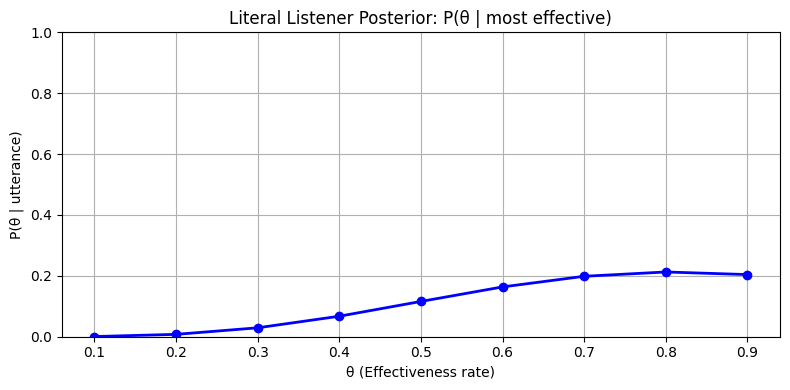

In [99]:
utt = ("most", "effective")
probs = literal_listener_theta_utterance(utt,thetas=thetas, n=1, m=7)
plot_literal_listener_theta_posterior(probs, thetas, utt)
#plot_utterance_histogram(probs)

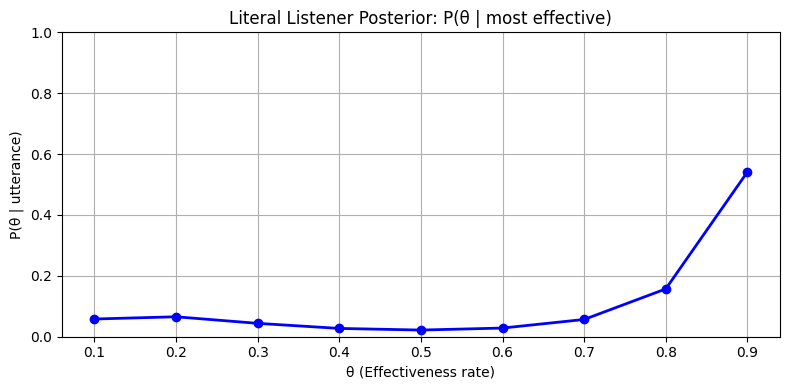

In [100]:
probs = literal_listener_theta_utterance(("some", "effective"),thetas=thetas, n=1, m=7, N=10000)
plot_literal_listener_theta_posterior(probs, thetas, ("most", "effective"))
#plot_utterance_histogram(probs)

In [62]:
def informativeness_speaker1(utterance, obs, thetas=thetas):
    if utterance_is_true(utterance, obs):
        theta_utt = literal_listener_theta_utterance(utterance, n=obs.shape[0], m=obs.shape[1], thetas=thetas)
        result = 0
        for theta in thetas:
            obs_theta = (theta ** np.sum(obs)) * ((1 - theta) ** (obs.size - np.sum(obs)))
            result += obs_theta * theta_utt[int(theta * 10 - 1)]
        return result
        
    else:
        return 0.0
    

In [13]:
from itertools import product
import numpy as np

def informativeness_all_utterances(obs, thetas, quantifiers=["none", "some", "most", "all"], N=1000):
    if obs.shape[0] > 1:
        utterances = list(product(quantifiers, quantifiers, ["effective", "ineffective"]))
    else:
        utterances = list(product(quantifiers, ["effective", "ineffective"]))
    result = {}
    print(f"obs shape: {obs.shape}, utterances: {len(utterances)}")
    total_successes = np.sum(obs)
    total_trials = obs.size

    for utt in utterances:
        if utterance_is_true(utt, obs):
            print(utt)
            theta_utt = literal_listener_theta_utterance(
                utt, n=obs.shape[0], m=obs.shape[1], thetas=thetas, N=N
            )
            info = 0.0
            for i, theta in enumerate(thetas):
                p_obs_given_theta = math.comb(obs.size, total_successes)* (theta ** total_successes) * ((1 - theta) ** (total_trials - total_successes))
                info += p_obs_given_theta * theta_utt[i]
            result[utt] = info
        else:
            result[utt] = 0.0

    return result


def pragmatic_speaker1_softmax(informativity_dict, alpha=1.0):
    utterances = list(informativity_dict.keys())
    probs = []
    for utt, info in informativity_dict.items():
        if info > 0:
            probs.append(info ** alpha)
        else:
            probs.append(0.0)
    probs = np.array(probs)
    probs /= np.sum(probs)  # Normalize to ensure probabilities sum to 1
    
    
    # infos = np.array([informativity_dict[u] for u in utterances])

    # infos_nonzero = infos[infos > 0]
    # # Softmax with temperature (α): exponentiate scaled informativeness
    # scaled = alpha * infos
    # # scaled -= np.max(scaled)  # For numerical stability
    # exp_scaled = np.exp(scaled)
    # exp_scaled.map(lambda x: 0 if x == 1 else x)  # Avoid division by zero
    # probs = exp_scaled / np.sum(exp_scaled)

    return {u: p for u, p in zip(utterances, probs)}

In [14]:
def plot_speaker_distribution(distribution, title="Speaker Distribution", alpha=1.0):
    """Plot speaker distribution over utterances (q2, predicate) in a fixed order."""
    utterance_order = [
        ("none", "ineffective"),
        ("none", "effective"),
        ("some", "ineffective"),
        ("some", "effective"),
        ("most", "ineffective"),
        ("most", "effective"),
        ("all", "ineffective"),
        ("all", "effective"),
    ]

    utterances = [f"{q2} {pred}" for (q2, pred) in utterance_order]
    probs = [distribution.get((q2, pred), 0.0) for (q2, pred) in utterance_order]

    plt.figure(figsize=(8, 5))
    bars = plt.barh(utterances, probs, color="steelblue")
    plt.xlabel("Probability")
    if alpha > 0:
        plt.title(f"{title} (α={alpha})")
    else:
        plt.title(title)
    plt.xlim(0, 1)

    # Add text labels
    for bar, prob in zip(bars, probs):
        if prob > 0.01:
            plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2,
                     f"{prob:.2f}", va="center", fontsize=9)

    plt.gca().invert_yaxis()  # Keep top-down order
    plt.tight_layout()

In [15]:
obs = (1, 0, 0, 0, 0, 0, 0, 0)
print(obs)
infos = informativeness_all_utterances(obs, thetas=np.linspace(0.1, 1.0, 10), N = 10000)
perss = persuasiveness_all_utterances("high", n = 1, m = 7, thetas=np.linspace(0.1, 1.0, 10), quantifiers=["none", "some", "most", "all"], predicates=["effective", "ineffective"], N = 1000)
speaker1_dist = pragmatic_speaker1_softmax(infos, perss, alpha=3.0, beta=0)
print(infos)
for u, p in sorted(speaker1_dist.items(), key=lambda x: -x[1]):
    if p > 0:
        print(f"{u}: {p}")

(1, 0, 0, 0, 0, 0, 0, 0)


AttributeError: 'tuple' object has no attribute 'shape'

In [16]:
cases = [(1, 0, 0, 0, 0, 0, 0, 0),
         (0, 0, 1, 0, 0, 0, 0, 0),
         (0, 0, 0, 0, 1, 0, 0, 0)]
for obs in cases:
    total_success = sum([obs[i] * i for i in range(len(obs))])
    infos = informativeness_all_utterances(obs, thetas=np.linspace(0.1, 1.0, 10), N = 10000)
    dist = pragmatic_speaker1_softmax(infos, alpha=3.0)
    plot_speaker_distribution(literal_speaker_utterance_obs(obs), title=f"Literal Speaker Distribution {total_success} / {len(obs) - 1}")
    plot_speaker_distribution(dist, title=f"Pragmatic Speaker Distribution {total_success} / {len(obs) - 1}", alpha=0)
    

AttributeError: 'tuple' object has no attribute 'shape'

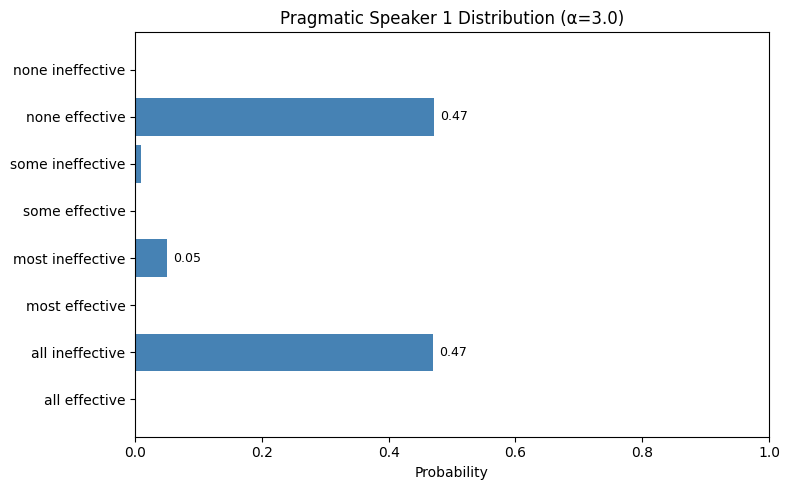

In [ ]:
plot_speaker_distribution(speaker1_dist, title="Pragmatic Speaker 1 Distribution", alpha=3.0)

In [52]:
print(obs)
for u, v in sorted(informativity_dict.items(), key=lambda x: -x[1]):
    if v > 0:
        print(f"{u}: {v}")


[[0 0 0 0 0 0 0]]
('none', 'most', 'ineffective'): 9.27627423442066e-09
('all', 'most', 'effective'): 9.247429340610746e-09
('some', 'none', 'ineffective'): 8.730990280507146e-09
('some', 'all', 'effective'): 8.72711786987095e-09
('most', 'most', 'effective'): 7.648487727680165e-09
('some', 'most', 'effective'): 5.599550822652746e-09
('none', 'none', 'effective'): 5.412106217144314e-09
('none', 'all', 'ineffective'): 5.387663477041723e-09
('all', 'some', 'effective'): 5.343900373712666e-09
('some', 'some', 'ineffective'): 4.555138495879732e-09
('most', 'some', 'effective'): 4.3944677758236834e-09
('most', 'some', 'ineffective'): 4.3670978726924015e-09
('some', 'some', 'effective'): 4.180856102150224e-09


In [35]:
obs = create_samples(0.8, 10, 5)
print("obs:\n", obs)

distribtuion = literal_speaker_utterance(obs)
def print_distribution(dist, threshold=0.0):
    print(f"{'Quantifier 1':<10} {'Quantifier 2':<10} {'Effectiveness':<12} {'Probability':<10}")
    print("-" * 50)
    
    for key, prob in sorted(dist.items(), key=lambda x: -x[1]):
        if prob >= threshold:
            q1, q2, eff = key
            print(f"{q1:<10} {q2:<10} {eff:<12} {prob:<10.3f}")
            
print_distribution(distribtuion, threshold=0.0)

obs:
 [[1 1 1 0 1]
 [1 1 1 0 0]
 [1 1 1 1 0]
 [1 0 1 1 1]
 [0 1 1 1 1]
 [1 1 0 1 0]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 0 1 1]
 [1 0 1 1 1]]
Quantifier 1 Quantifier 2 Effectiveness Probability
--------------------------------------------------
all        most       effective    0.077     
all        some       effective    0.077     
most       most       effective    0.077     
most       some       effective    0.077     
some       all        effective    0.077     
some       most       effective    0.077     
some       some       effective    0.077     
none       none       effective    0.077     
most       some       ineffective  0.077     
some       some       ineffective  0.077     
some       none       ineffective  0.077     
none       all        ineffective  0.077     
none       most       ineffective  0.077     
all        all        effective    0.000     
all        none       effective    0.000     
most       all        effective    0.000     
most       none       ef

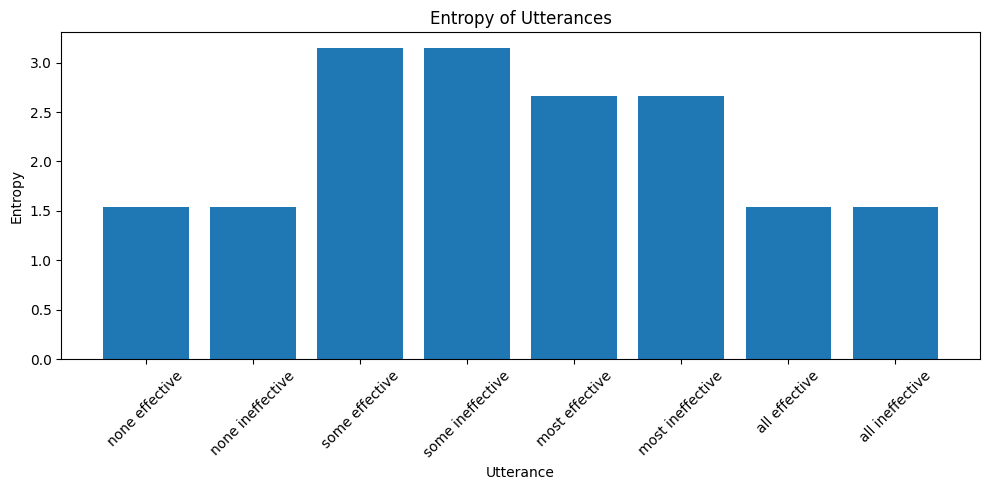

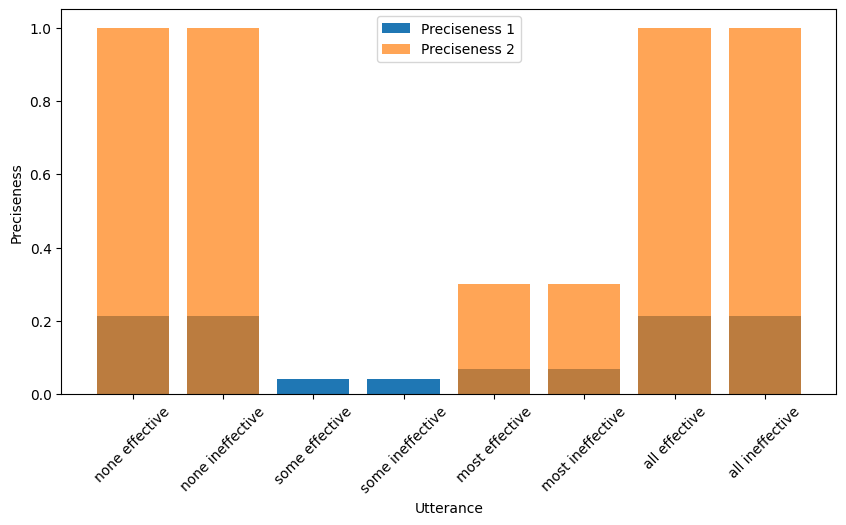

In [20]:
entropies = {}
utterances = list(product(quantifiers, predicates))
n = 1
m = 7
for utterance in utterances:
    dist = literal_listener_theta_utterance(utterance, n=n, m=m)
    entropy = -sum(p * np.log2(p) for p in dist if p > 0)
    entropies[utterance] = entropy

preciseness1 = {u: 1 / np.exp(ent) for u, ent in entropies.items()}
max_entropy = max(entropies.values())
min_entropy = min(entropies.values())
preciseness2 = {u: 1 - (ent - min_entropy) / (max_entropy - min_entropy) for u, ent in entropies.items()}


#plot entropies
plt.figure(figsize=(10, 5))
plt.bar(range(len(entropies)), list(entropies.values()), align='center')
plt.xticks(range(len(entropies)), [f"{q2} {pred}" for (q2, pred) in entropies.keys()], rotation=45)
plt.xlabel("Utterance")
plt.ylabel("Entropy")
plt.title("Entropy of Utterances")
plt.tight_layout()

#plot precisions
plt.figure(figsize=(10, 5))
plt.bar(range(len(preciseness1)), list(preciseness1.values()), align='center', label='Preciseness 1')
plt.bar(range(len(preciseness2)), list(preciseness2.values()), align='center', label='Preciseness 2', alpha=0.7)
plt.xticks(range(len(preciseness1)), [f"{q2} {pred}" for (q2, pred) in preciseness1.keys()], rotation=45)
plt.xlabel("Utterance")
plt.ylabel("Preciseness")
plt.legend()

In [ ]:
preciseness = {}
for interval_range in range(0, 101):
    